<a href="https://colab.research.google.com/github/pingwx/pet.proj/blob/main/poker_hand_guesser_part1/hand_guesser_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сила руки в покере

Многие из нас знакомы с карточной игрой покер. У нее есть много разновидностей: Hold'em, Omaha, Five-card draw и другие. В большинстве вариантов покера игроки стремятся собрать лучшую комбинацию из пяти карт (руку). Не каждая покерная раздача заканчивается показом карт игроками. Если все игроки, кроме одного спасовали, раздачу выигрывает неспасовавший игрок. Он имеет право не показывать карты остальным. Однако, если все круги торговли завершены, а игроков в банке больше одного, они обязаны показать карты. Побеждает игрок, у которого самая сильная рука. Вот список возможных комбинаций, которые собирают игроки почти в любой разновидности покера. Они отсортированы от старшей к младшей.


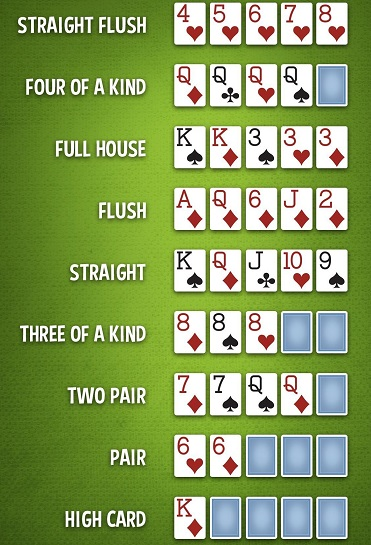

Старшинство комбинаций в покере:
- Straight Flush. Пять карт одной масти, идущие подряд.
- Four of a kind. Четыре карты одного достоинства.
- Full house. Три карты одного достоинства и две другого.
- Flush. Пять карт одной масти.
- Straight. Пять карт, идущие подряд.
- Three of a kind. Три карты одного достоинства.
- Two pair. Две карты одного достоинства и две другого.
- Pair. Две карты одного достоинства.
- High Card. Ничего из вышеперечисленного.

Рассмотрим разновидность покера Texas Hold'em. В ней игрок составляет пятикарточную комбинацию из семи доступных карт: две в руке игрока, пять общих карт на столе. Лучшая возможная комбинация, полученная выбором пяти карт из семи, является итоговой комбинацией игрока.

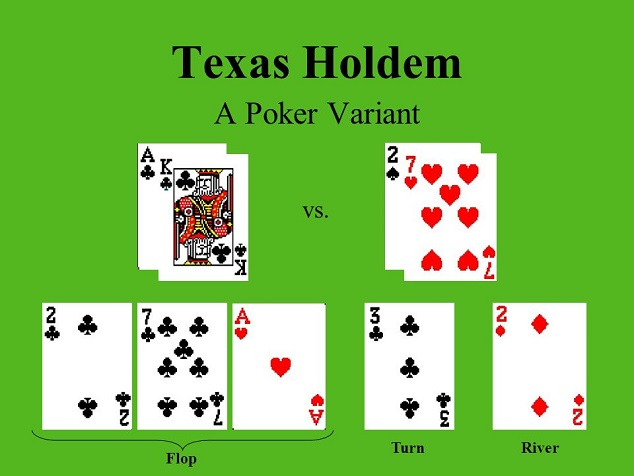

На этом примере мы видим, что игрок слева собрал комбинацию Флаш, а игрок справа - Фулл хаус (три двойки, две семерки). Игрок справа выигрывает на вскрытии (showdown), потому что его комбинация старше.

#Эксперимент по обучению машины определять силу руки

Предположим, что мы ничего не знаем о покере, комбинациях, старшинстве и прочем. В нашем распоряжении есть размеченный датасет, в котором есть данные о картах, сданных игроку, картах, сданных на стол и известна итоговая сила руки. Сможет ли машина найти зависимости и научиться по семи картам определять итоговую комбинацию? Это типичная задача мультиклассификации.

In [ ]:
# !gdown 1yIQcSK_U4H39SNUeo5Orf1X3r-ZblCFd # загрузка датасета

In [ ]:
# !pip install catboost # установка катбуста

In [ ]:
import pandas as pd
import numpy as np
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Javascript

In [ ]:
df = pd.read_csv('/content/guess_the_hand.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569612 entries, 0 to 569611
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id_hand          569612 non-null  int64 
 1   hero_card1_rank  569612 non-null  int64 
 2   hero_card1_suit  569612 non-null  object
 3   hero_card2_rank  569612 non-null  int64 
 4   hero_card2_suit  569612 non-null  object
 5   flop_card1_rank  569612 non-null  int64 
 6   flop_card1_suit  569612 non-null  object
 7   flop_card2_rank  569612 non-null  int64 
 8   flop_card2_suit  569612 non-null  object
 9   flop_card3_rank  569612 non-null  int64 
 10  flop_card3_suit  569612 non-null  object
 11  turn_card_rank   569612 non-null  int64 
 12  turn_card_suit   569612 non-null  object
 13  river_card_rank  569612 non-null  int64 
 14  river_card_suit  569612 non-null  object
 15  hero_cards       569612 non-null  object
 16  flop             569612 non-null  object
 17  turn      

Посмотрим, как выглядит наша таблица.

In [ ]:
df.head()

,id_hand,hero_card1_rank,hero_card1_suit,hero_card2_rank,hero_card2_suit,flop_card1_rank,flop_card1_suit,flop_card2_rank,flop_card2_suit,flop_card3_rank,flop_card3_suit,turn_card_rank,turn_card_suit,river_card_rank,river_card_suit,hero_cards,flop,turn,river,combination
0,600508,13,d,12,h,14,h,13,h,6,s,2,h,10,s,KdQh,AhKh6s,2h,Ts,One pair
1,600509,14,c,7,c,6,s,3,d,2,d,11,h,2,s,Ac7c,6s3d2d,Jh,2s,One pair
2,600510,12,d,4,c,6,h,5,s,4,h,8,s,3,d,Qd4c,6h5s4h,8s,3d,One pair
3,600511,10,h,8,h,12,d,7,s,3,c,4,s,13,s,Th8h,Qd7s3c,4s,Ks,High card
4,600512,11,h,2,h,13,h,10,d,5,s,9,c,9,h,Jh2h,KhTd5s,9c,9h,One pair


Мы видим следующую структуру. Каждая карта определяется двумя столбцами: ранг карты (Туз(A) = 14, Король(K) = 13, Дама(Q) = 12 и тд) и ее масть (Черва = h, Бубна = d, Трефа = с, Пика = s). Также есть столбцы, в которых карты игрока и стола записаны в классической покерной нотации. Вот в таком виде таблица выглядит намного нагляднее.

In [ ]:
NOTATION = ['hero_cards', 'flop', 'turn', 'river', 'combination']
df[NOTATION].head()

,hero_cards,flop,turn,river,combination
0,KdQh,AhKh6s,2h,Ts,One pair
1,Ac7c,6s3d2d,Jh,2s,One pair
2,Qd4c,6h5s4h,8s,3d,One pair
3,Th8h,Qd7s3c,4s,Ks,High card
4,Jh2h,KhTd5s,9c,9h,One pair


Наш целевой признак, который мы хотим научиться угадывать - столбец `combination`. Посмотрим, как распределены в нем значения.

In [ ]:
distribution = df['combination'].value_counts() / len(df) * 100
distribution

One pair           43.906203
Two pair           23.349227
High card          17.380076
Three of a kind     4.849266
Straight            4.666861
Flush               3.028377
Full house          2.627578
Four of a kind      0.162216
Straight flush      0.030196
Name: combination, dtype: float64

Теоретическое распределение вероятностей получить ту или иную комбинацию выглядит следующим образом:

In [ ]:
theoretical_distribution = {'One pair': 43.8, 'Two pair': 23.5, 'High card': 17.41, 'Three of a kind': 4.82,
                            'Straight': 4.61, 'Flush': 3.03, 'Full house': 2.59, 'Four of a kind': 0.168,
                            'Straight flush': 0.03}
theoretical_distribution                           

{'Flush': 3.03,
 'Four of a kind': 0.168,
 'Full house': 2.59,
 'High card': 17.41,
 'One pair': 43.8,
 'Straight': 4.61,
 'Straight flush': 0.03,
 'Three of a kind': 4.82,
 'Two pair': 23.5}

Теоретические вероятности получения комбинаций на графике

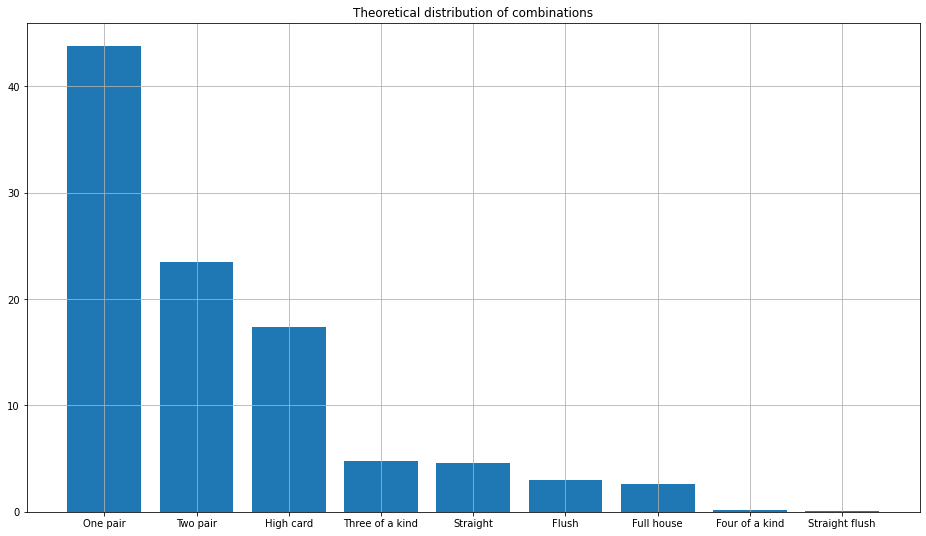

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Theoretical distribution of combinations')
plt.grid()
plt.bar(range(len(theoretical_distribution)),
        list(theoretical_distribution.values()),
        tick_label=list(theoretical_distribution.keys()))
plt.show()

График распределения столбца `combination` в нашем датасете

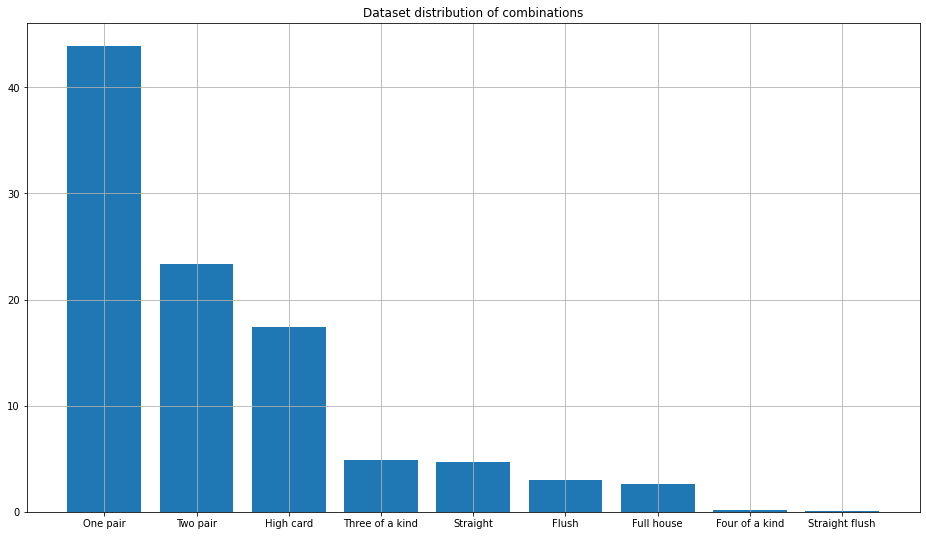

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Dataset distribution of combinations')
plt.grid()
plt.bar(range(len(distribution)),
        distribution.values,
        tick_label = distribution.index.to_list())
plt.show()

Как видно из двух графиков, распределение столбца `combination` совпадает с теоретическим. Наложив графики друг на друга, они практически сольются. Мы убедились, что наш датасет получен честно. Возможно, это чья-то история раздач.

Из данного распределения становится понятно, почему старшинство комбинаций именно такое, а не какое-то другое. Видно, что наиболее сильные комбинации трудно собрать, Four of a kind и Straight flush встречаются довольно редко. Вот примеры раздач, где игроку это удалось.

In [ ]:
df[NOTATION].query('combination in ["Straight flush", "Four of a kind"]').head()

,hero_cards,flop,turn,river,combination
266,Ac7s,AhTh9h,Ad,As,Four of a kind
784,Ah2d,AdAc4s,Qh,As,Four of a kind
1525,3s3h,Qc4c3d,2d,3c,Four of a kind
2104,5d4d,Ad3d2d,Th,7h,Straight flush
2733,Kd2d,2s2h2c,Ah,Ts,Four of a kind


## Замечания по исследованию
В этой работе мы не будем вдаваться в разные классификаторы и их тюнинг. Вместо этого, мы посмотрим, как обучается модель, в зависимости от того, сколько данных ей дать. Поскольку наш датасет достаточно большой, мы имеем такую возможность. Мы надеемся, что зависимости будут найдены машиной даже на малом числе образцов.

## Вспомогательная функция для предобработки

Ниже идет код, предобрабатывающий данные в нужный формат для нашей модели. Тут отметим, что масть карты - всегда категориальный признак. А ранг карты можно рассмартривать и с численной (Туз(14) старше Короля(13)), и с категориальной точек зрения. В предобработке предусмотрена такая возможность. Данные будут семплироваться заданным размером. 75% данных будут использоваться для обучения, оставшиеся 25% - для теста.

In [ ]:
# Предобработка данных для CatBoostClassifier
def prepare_for_cb(data, sample_size, rank_as_category=True):
  data_sample = data.sample(n=sample_size, random_state=2007).copy()
  data_sample = data_sample.drop(['hero_cards', 'flop', 'turn', 'river', 'id_hand'], axis=1)
  if rank_as_category:
    cat_features = ['hero_card1_rank',	'hero_card1_suit', 'hero_card2_rank',
                     'hero_card2_suit', 'flop_card1_rank', 'flop_card1_suit',
                     'flop_card2_rank',	'flop_card2_suit',	'flop_card3_rank',
                     'flop_card3_suit',	'turn_card_rank', 'turn_card_suit', 
                     'river_card_rank',	'river_card_suit']
  else:
    cat_features = ['hero_card1_suit', 'hero_card2_suit', 'flop_card1_suit',
                     'flop_card2_suit','flop_card3_suit','turn_card_suit',
                     'river_card_suit']
  X = data_sample.drop('combination', axis=1)
  y = data_sample['combination']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2007)
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_features)
  return train_data, X_test, y_test

## Используемая модель

Мы будем пробовать модель CatBoostClassifier с дефолтными настройками. Известно, что Catboost сам неплохо справляется с подбором параметров.

In [ ]:
def run_cb(data, sample_size, rank_as_category=True, save_model=False):
  train_data, X_test, y_test = prepare_for_cb(data=data, sample_size=sample_size, rank_as_category=rank_as_category)
  print('Training on', int(sample_size*0.75), 'samples')
  print('Testing on', int(sample_size*0.25), 'samples')
  print ('')
  model = CatBoostClassifier(random_state=2007)
  print('Fitting the model ...')
  model.fit(train_data, verbose=100)
  predict = pd.DataFrame(model.predict(X_test))
  print('')
  print('Predicted labels value counts:')
  print('')
  display(predict.value_counts())
  distribution = predict.value_counts()/len(predict)*100
  plt.figure(figsize=(16, 9))
  plt.title('Theoretical and predicted distributions of combinations')
  plt.grid()
  plt.bar(range(len(theoretical_distribution)),
        list(theoretical_distribution.values()),
        tick_label=list(theoretical_distribution.keys()),
        alpha=0.5)
  plt.bar(range(len(distribution)),
        distribution.values,
        #tick_label = distribution.index.to_list(),
        alpha=0.5)
  plt.legend(['Theoretical', 'Predicted'])
  plt.show()
  labels = pd.Series(y_test).unique()
  cm = confusion_matrix(y_test, predict, labels=labels)
  plt.figure(figsize=(16, 16))
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g')
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
  plt.show()
  print('')
  print('----------- CLASSIFICATION REPORT -----------')
  print('')
  print(classification_report(y_test, predict, zero_division=0))
  if save_model:
    model.save_model('cb_'+str(sample_size))

# Работа модели

Далее будем запускать классификатор, подразумевая ранги карт, как категориальные величины. Экспериментально установлено, что так лучше. Но если очень хочется попробовать, добавьте в вызов функции run_cb третьим аргументом rank_as_category=False

## Размер выборки = 5000

In [ ]:
SAMPLE_SIZE = 5000

<IPython.core.display.Javascript object>

Training on 3750 samples
Testing on 1250 samples

Fitting the model ...
Learning rate set to 0.084645
0:	learn: 1.9800313	total: 148ms	remaining: 2m 27s
100:	learn: 1.3735094	total: 57s	remaining: 8m 27s
200:	learn: 1.1151294	total: 1m 43s	remaining: 6m 50s
300:	learn: 0.9200024	total: 2m 30s	remaining: 5m 49s
400:	learn: 0.7679894	total: 3m 17s	remaining: 4m 55s
500:	learn: 0.6450344	total: 4m 6s	remaining: 4m 5s
600:	learn: 0.5440521	total: 4m 54s	remaining: 3m 15s
700:	learn: 0.4659909	total: 5m 41s	remaining: 2m 25s
800:	learn: 0.4026996	total: 6m 28s	remaining: 1m 36s
900:	learn: 0.3509887	total: 7m 16s	remaining: 47.9s
999:	learn: 0.3090525	total: 8m 3s	remaining: 0us

Predicted labels value counts:



One pair     946
Two pair     231
High card     73
dtype: int64

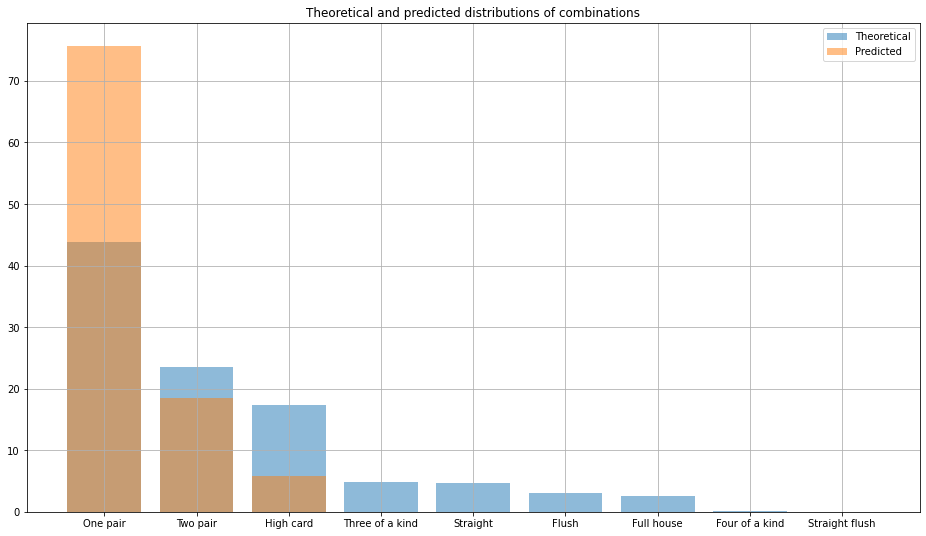

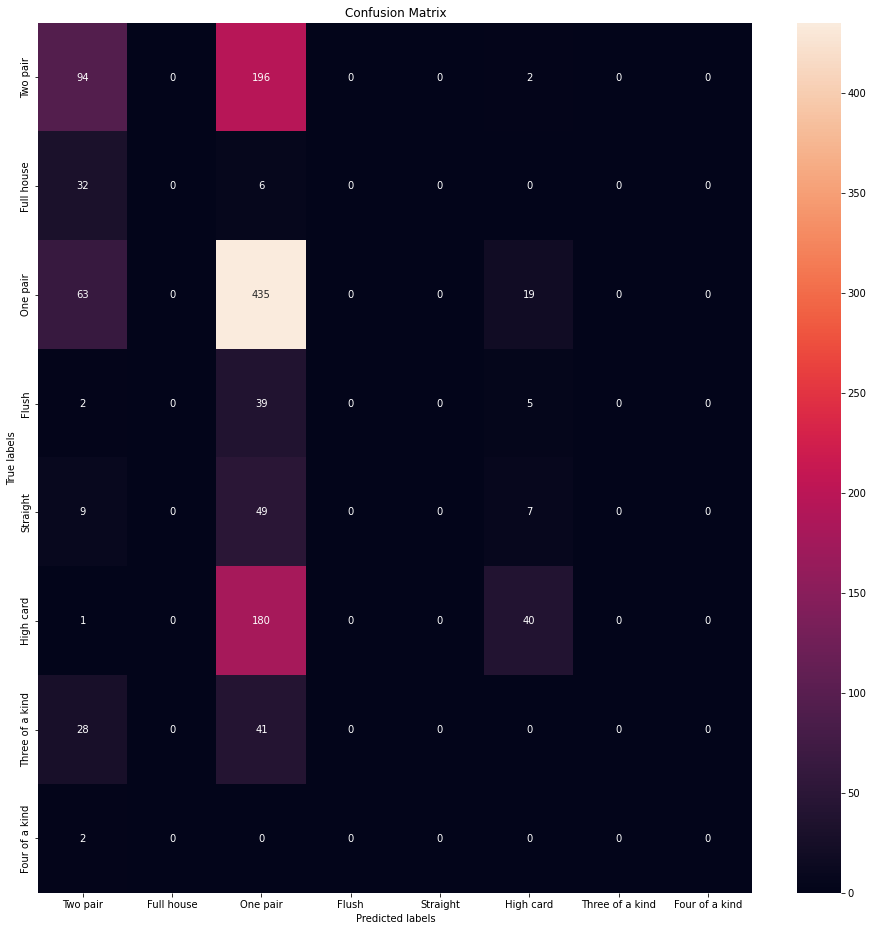


----------- CLASSIFICATION REPORT -----------

                 precision    recall  f1-score   support

          Flush       0.00      0.00      0.00        46
 Four of a kind       0.00      0.00      0.00         2
     Full house       0.00      0.00      0.00        38
      High card       0.55      0.18      0.27       221
       One pair       0.46      0.84      0.59       517
       Straight       0.00      0.00      0.00        65
Three of a kind       0.00      0.00      0.00        69
       Two pair       0.41      0.32      0.36       292

       accuracy                           0.46      1250
      macro avg       0.18      0.17      0.15      1250
   weighted avg       0.38      0.46      0.38      1250

CPU times: user 11min 33s, sys: 3min 5s, total: 14min 39s
Wall time: 8min 4s


In [ ]:
%%time
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
run_cb(df, SAMPLE_SIZE)

Налицо явный недостаток сэмплов. Модель видела мало образцов комбинаций старше двух пар. Кое-какие скоры для часто встречающихся комбинаций начинают появляться, но качество неудовлетворительное. Катбуст из коробки долго учится, как видно, даже на малом числе семплов.

##Размер выборки = 25000

In [ ]:
SAMPLE_SIZE = 25000

<IPython.core.display.Javascript object>

Training on 18750 samples
Testing on 6250 samples

Fitting the model ...
Learning rate set to 0.091885
0:	learn: 2.0603737	total: 169ms	remaining: 2m 49s
100:	learn: 1.1166995	total: 2m 18s	remaining: 20m 31s
200:	learn: 0.8841022	total: 4m 59s	remaining: 19m 50s
300:	learn: 0.7827678	total: 7m 41s	remaining: 17m 51s
400:	learn: 0.7118337	total: 10m 22s	remaining: 15m 30s
500:	learn: 0.6573959	total: 13m 9s	remaining: 13m 6s
600:	learn: 0.6076569	total: 15m 54s	remaining: 10m 33s
700:	learn: 0.5662328	total: 18m 39s	remaining: 7m 57s
800:	learn: 0.5316171	total: 21m 27s	remaining: 5m 19s
900:	learn: 0.4977709	total: 24m 12s	remaining: 2m 39s
999:	learn: 0.4641542	total: 27m 1s	remaining: 0us

Predicted labels value counts:



One pair           2986
Two pair           1539
High card          1202
Three of a kind     273
Flush               146
Full house           84
Straight             20
dtype: int64

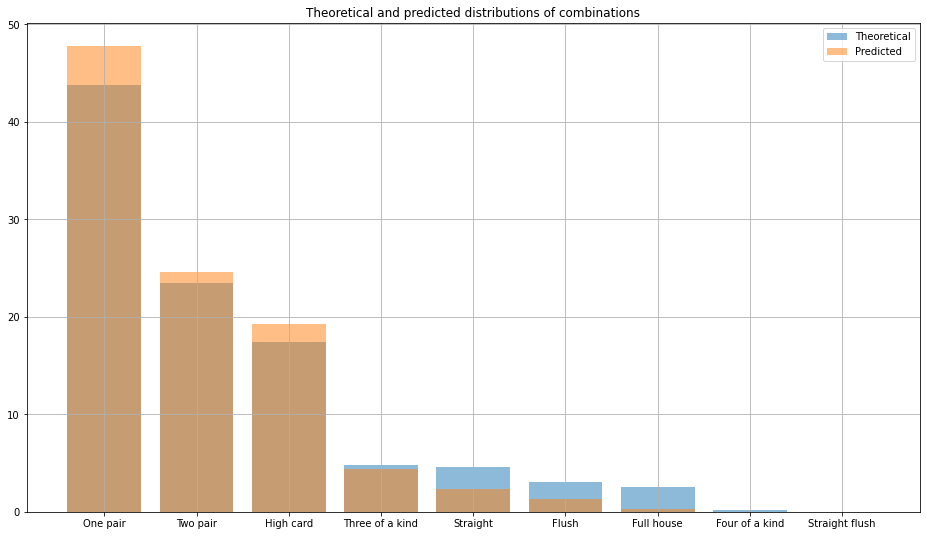

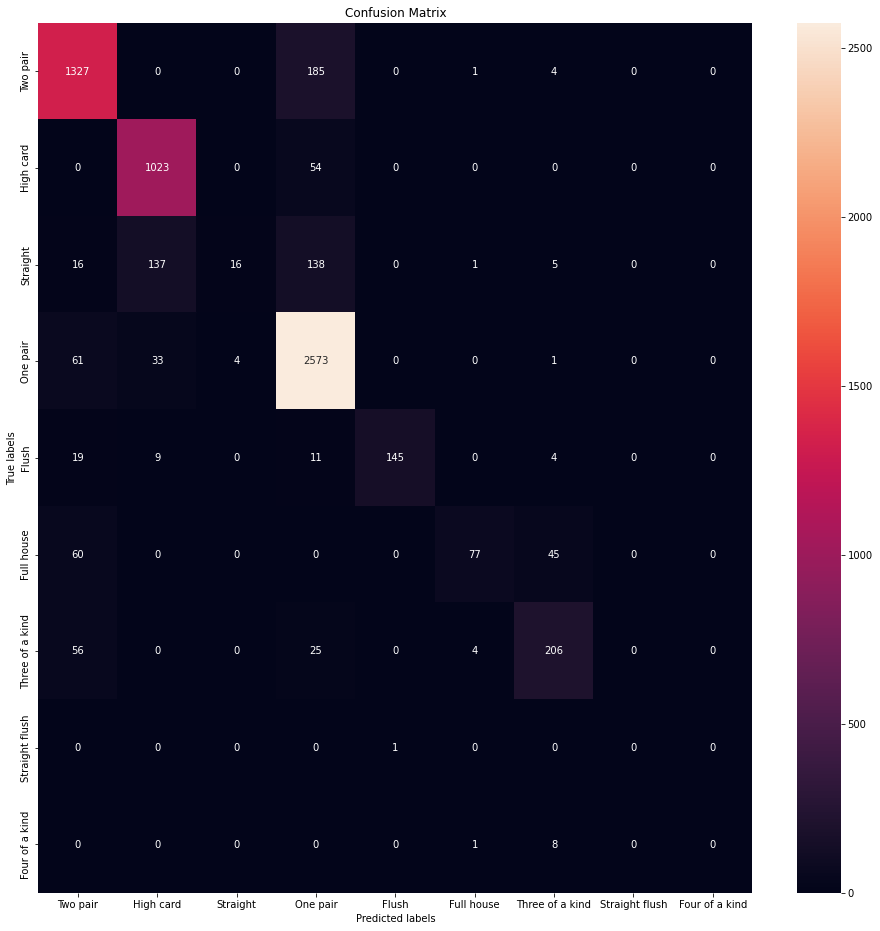


----------- CLASSIFICATION REPORT -----------

                 precision    recall  f1-score   support

          Flush       0.99      0.77      0.87       188
 Four of a kind       0.00      0.00      0.00         9
     Full house       0.92      0.42      0.58       182
      High card       0.85      0.95      0.90      1077
       One pair       0.86      0.96      0.91      2672
       Straight       0.80      0.05      0.10       313
 Straight flush       0.00      0.00      0.00         1
Three of a kind       0.75      0.71      0.73       291
       Two pair       0.86      0.87      0.87      1517

       accuracy                           0.86      6250
      macro avg       0.67      0.53      0.55      6250
   weighted avg       0.86      0.86      0.84      6250

CPU times: user 48min 26s, sys: 4min 4s, total: 52min 31s
Wall time: 27min 3s


In [ ]:
%%time
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
run_cb(df, SAMPLE_SIZE, save_model=True)

Неплохие скоры получили. Аккураси выглядит солидно. Плохо угадываем комбинации, старше сета. Но в слабых комбинациях разобрались вроде неплохо. И это всего на 18750 раздачах учились. Время обучения растет тоже заметно.

##Размер выборки = 125000

In [ ]:
SAMPLE_SIZE = 125000

<IPython.core.display.Javascript object>

Training on 93750 samples
Testing on 31250 samples

Fitting the model ...
Learning rate set to 0.099746
0:	learn: 2.0499278	total: 836ms	remaining: 13m 54s
100:	learn: 0.8263067	total: 10m 25s	remaining: 1h 32m 50s
200:	learn: 0.5428387	total: 22m 20s	remaining: 1h 28m 49s
300:	learn: 0.4307537	total: 34m 14s	remaining: 1h 19m 31s
400:	learn: 0.3728598	total: 46m 4s	remaining: 1h 8m 49s
500:	learn: 0.3382805	total: 57m 46s	remaining: 57m 33s
600:	learn: 0.3155061	total: 1h 9m 27s	remaining: 46m 6s
700:	learn: 0.2984291	total: 1h 21m 4s	remaining: 34m 34s
800:	learn: 0.2836128	total: 1h 32m 55s	remaining: 23m 5s
900:	learn: 0.2711914	total: 1h 44m 34s	remaining: 11m 29s
999:	learn: 0.2605206	total: 1h 56m 10s	remaining: 0us

Predicted labels value counts:



One pair           14064
Two pair            7408
High card           6034
Three of a kind     1542
Flush                927
Full house           819
Straight             425
Four of a kind        31
dtype: int64

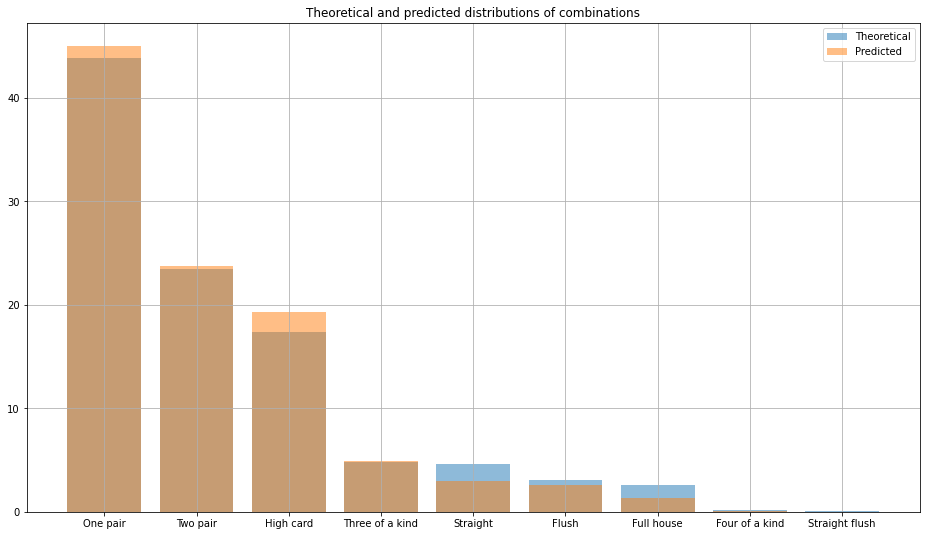

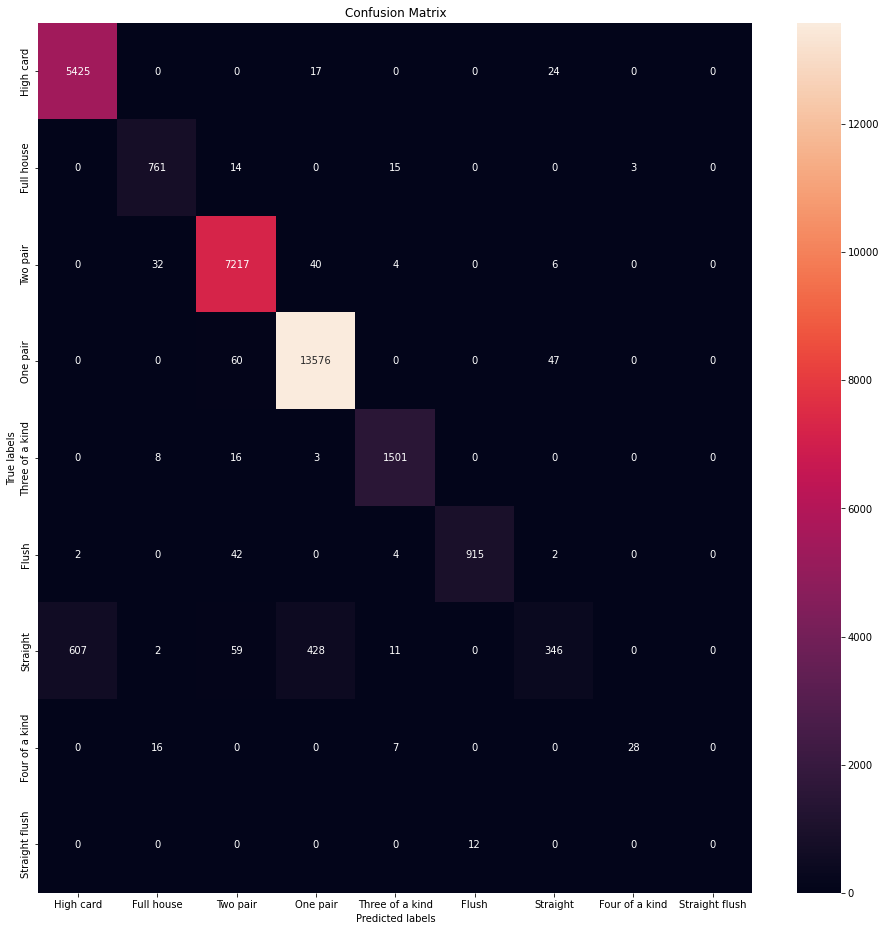


----------- CLASSIFICATION REPORT -----------

                 precision    recall  f1-score   support

          Flush       0.99      0.95      0.97       965
 Four of a kind       0.90      0.55      0.68        51
     Full house       0.93      0.96      0.94       793
      High card       0.90      0.99      0.94      5466
       One pair       0.97      0.99      0.98     13683
       Straight       0.81      0.24      0.37      1453
 Straight flush       0.00      0.00      0.00        12
Three of a kind       0.97      0.98      0.98      1528
       Two pair       0.97      0.99      0.98      7299

       accuracy                           0.95     31250
      macro avg       0.83      0.74      0.76     31250
   weighted avg       0.95      0.95      0.94     31250

CPU times: user 3h 41min 6s, sys: 5min 22s, total: 3h 46min 28s
Wall time: 1h 56min 15s


In [ ]:
%%time
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
run_cb(df, SAMPLE_SIZE, save_model=True)

95% аккураси, модель почти все поняла. Как видно из матрицы ошибок и репорта, модели тяжело даются стриты. Настоящие стриты модель часто называет парой и старшей картой. Сэмпл стрит-флашей все еще маленький, его модель почти не видела. Все стрит-флаши модель назвала флашами, что приемлемо.

##Размер выборки = ПОЛНЫЙ ДАТАСЕТ

In [ ]:
SAMPLE_SIZE = len(df)

<IPython.core.display.Javascript object>

Training on 427209 samples
Testing on 142403 samples

Fitting the model ...
Learning rate set to 0.107767
0:	learn: 2.0393091	total: 8.89s	remaining: 2h 28m 3s
100:	learn: 0.5591295	total: 48m 47s	remaining: 7h 14m 13s
200:	learn: 0.3337430	total: 1h 42m 6s	remaining: 6h 45m 52s
300:	learn: 0.2470712	total: 2h 34m 32s	remaining: 5h 58m 53s
400:	learn: 0.2045387	total: 3h 26m 18s	remaining: 5h 8m 10s
500:	learn: 0.1769048	total: 4h 18m 9s	remaining: 4h 17m 7s
600:	learn: 0.1610218	total: 5h 10m 9s	remaining: 3h 25m 54s
700:	learn: 0.1494403	total: 6h 1m 14s	remaining: 2h 34m 4s
800:	learn: 0.1411116	total: 6h 52m 13s	remaining: 1h 42m 24s
900:	learn: 0.1352771	total: 7h 42m 39s	remaining: 50m 50s
999:	learn: 0.1299084	total: 8h 32m 51s	remaining: 0us

Predicted labels value counts:



One pair           63331
Two pair           33349
High card          26172
Three of a kind     6921
Flush               4350
Straight            4195
Full house          3826
Four of a kind       252
Straight flush         7
dtype: int64

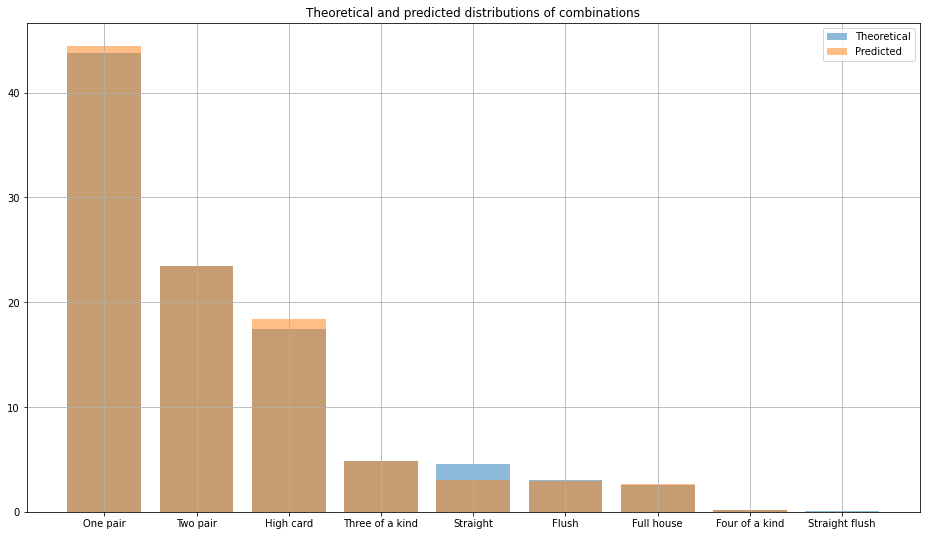

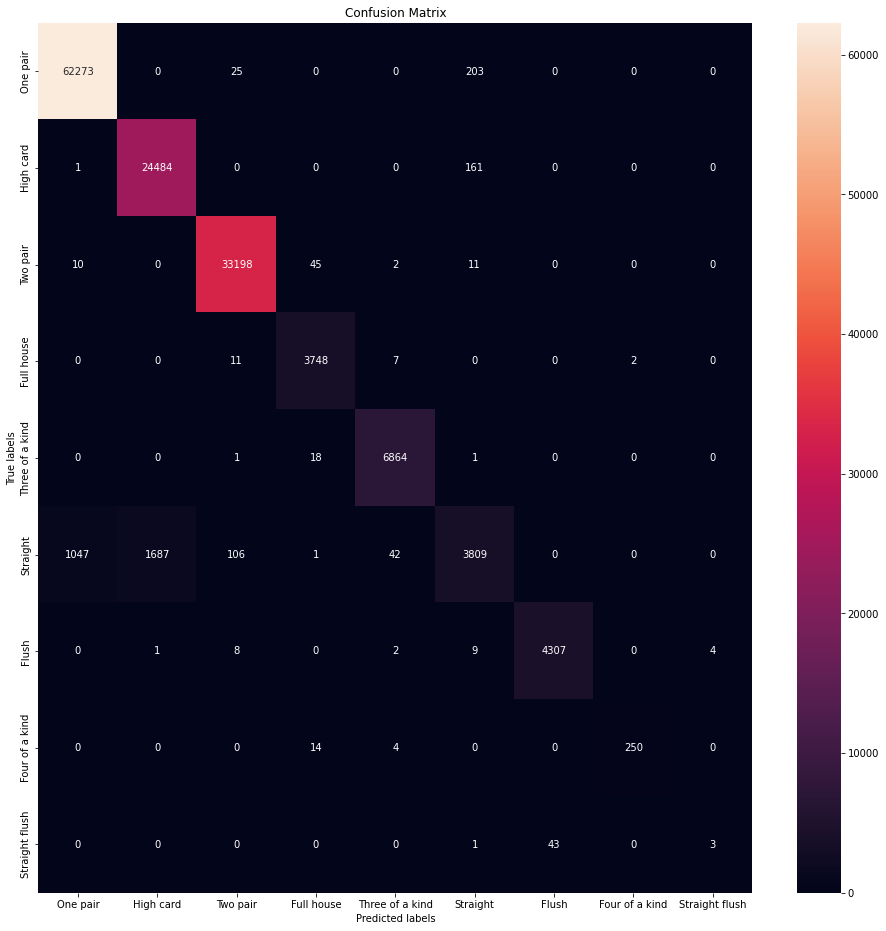


----------- CLASSIFICATION REPORT -----------

                 precision    recall  f1-score   support

          Flush       0.99      0.99      0.99      4331
 Four of a kind       0.99      0.93      0.96       268
     Full house       0.98      0.99      0.99      3768
      High card       0.94      0.99      0.96     24646
       One pair       0.98      1.00      0.99     62501
       Straight       0.91      0.57      0.70      6692
 Straight flush       0.43      0.06      0.11        47
Three of a kind       0.99      1.00      0.99      6884
       Two pair       1.00      1.00      1.00     33266

       accuracy                           0.98    142403
      macro avg       0.91      0.84      0.86    142403
   weighted avg       0.97      0.98      0.97    142403

CPU times: user 16h 35min, sys: 7min 37s, total: 16h 42min 37s
Wall time: 8h 33min 10s


In [ ]:
%%time
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
run_cb(df, SAMPLE_SIZE, save_model=True)

Почти идеально) Модель по-прежнему  путается в определении стритовых комбинаций. Определять остальные практически идеально обучилась.

# Выводы

Известно, что всего существует 133,784,560 различных комбинаций из семи карт. Наша модель видела при обучении не более 0.5% от этого числа, хотя относительное приемлемые скоры получились и на меньшем числе сэмплов. Ошибки модели при определении стритов очень похожи на человеческие: человек никогда не пропустит, например, комбинацию флаша в своей руке, а стриты часто "мисс-ридаются" человеком. Отметим, конечно, что для задачи определения силы руки, МЛ подход является не более, чем равзлечением, поскольку правила покера - информация всем доступная и классифицировать можно просто указав машине их в явном виде.